## Setup

In [32]:
%run code.py
%matplotlib inline
time_all_start = datetime.now()

In [33]:
# file and tree names

# MC
sig_file_name = 'data/all_el.root'
bkg_file_name = 'data/all_mu.root'
sig_tree  = 'electron_mc'
bkg_tree  = 'muon_mc'

# data
# sig_tree  = 'electron_tags'
# bkg_tree  = 'muons'

In [44]:
# other settings

fit_verbose = 1

# max_epochs = 100
max_epochs = 200

rnd_seed = 7

plot_mi = True

## Setup variables to train on

In [8]:
input_variables = OrderedDict([
    ('p',['$p$','default']),
    ('pT',['$p_{\mathrm{T}}$','default']),
    ('eta',['$\eta$','symmetric']),
    ('nTRThitsMan',['nTRT','default']),
    ('nTRTouts',['nTRT outs','default']),
    ('fHTMB',['Fraction HTMB','default']),
    ('fAr',['Fraction Ar','default']),
    ('trkOcc',['Track Occ.','default']),
    ('sumToTsumL',['$\sum\mathrm{ToT} / \sum L$','default']),
#    ('lep_pT',['$p_{\mathrm{T}}^{\mathrm{lep}}$','default']),
#    ('phi',['$\phi$','default']),
])

## vars to test
# PHF
# NhitsdEdx

# sumToT, sumL

# try adding eProbHT to see what else the network has learned

# all the hit vars, arrays of length 40 for use in RNN LSTM

# uninteresting vars - info is already included elsewhere
# nTRThits, nArhits, nXehits, nHThitsMan, nPrechitsMan
print(list(input_variables))

['p', 'pT', 'eta', 'nTRThitsMan', 'nTRTouts', 'fHTMB', 'fAr', 'trkOcc', 'sumToTsumL']


In [9]:
var_names_dict = {k:v[0] for (k,v) in input_variables.items()}

In [10]:
var_comb_dir = ''
for i,v in enumerate(input_variables.keys()):
    if i != 0: var_comb_dir += '_'
    var_comb_dir += v
plots_path = 'plots/'+var_comb_dir
models_path = 'models/'+var_comb_dir
make_path(plots_path)
make_path(models_path)

In [16]:
# df_sig, df_bkg, X_train, X_test, y_train, y_test = create_df_tts_scale(
#    sig_file_name, sig_tree, bkg_file_name, bkg_tree,
#    list(input_variables),
#    test_size=0.2,
#    # test_size=0.333333,
#    # sig_n=50000,
#    # bkg_n=50000,
#    shuffle=True,
#    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())}
# )

df_sig, df_bkg, X_train, X_test, y_train, y_test = create_fixed_test_shuffled_train_and_scale(
    sig_file_name, sig_tree, bkg_file_name, bkg_tree,
    list(input_variables),
    test_size=0.2,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    scale_style={i:v[1] for i,(_,v) in enumerate(input_variables.items())},
    rnd_seed = rnd_seed
)

# val_data=None
val_data=(X_test, y_test) # TODO bad form?

In [17]:
input_ndimensions = X_train.shape[1]
leptons_m = y_train.shape[0]

print("Training on m = %.2g leptons\nTesting on %.2g leptons (50/50 e/mu)\nNumber of input variables n = %d" % (leptons_m, y_test.shape[0], input_ndimensions))

Training on m = 1.4e+06 leptons
Testing on 2.9e+05 leptons (50/50 e/mu)
Number of input variables n = 9


In [18]:
if False:
    print(df_sig.head(3))
    print(X_train.shape)
    print(X_train[:2])

## Create eProbabilityHT curves

In [19]:
# TODO this technically has the issue with the high pT events, but shouldn't actually be visible on plots
el_eprob = uproot.open(sig_file_name)[sig_tree].array('eProbHT')
mu_eprob = uproot.open(bkg_file_name)[bkg_tree].array('eProbHT')

m_eprob = min(el_eprob.shape[0], mu_eprob.shape[0])
el_eprob = el_eprob[:m_eprob]
mu_eprob = mu_eprob[:m_eprob]
print('Using %.2g el, %.2g mu for eProbHT' % (el_eprob.shape[0], mu_eprob.shape[0]))

roc_eprob_obj = eprob_roc_generateor(el_eprob, mu_eprob)

roc_eprob = [roc_eprob_obj.tpr(), roc_eprob_obj.fpr(), 'eProbHT', 'eprob', 'black', '-']

Using 7.2e+05 el, 7.2e+05 mu for eProbHT


## Plot input variables

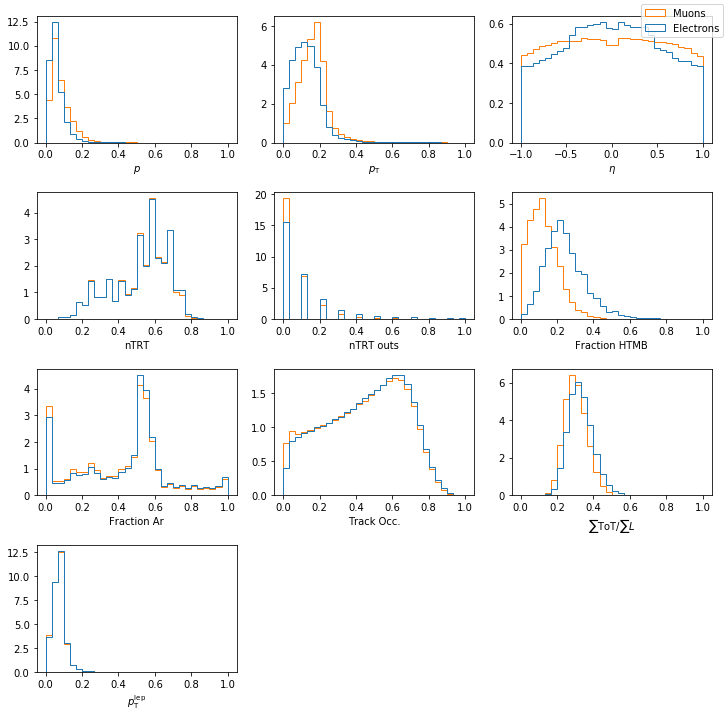

In [11]:
plot_all_input_vars(input_variables, X_train, y_train, plots_path)

In [20]:
lep_pT_bins = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.4, 1.0]
slice_and_plot_all_input_vars('lep_pT', '$p_{\mathrm{T}}^{\mathrm{lep}}$', lep_pT_bins, 
                              input_variables, X_train, y_train, plots_path)

ValueError: 'lep_pT' is not in list

In [37]:
# plot_scale_example(sig_file_name,sig_tree,plots_path,'p','$p$ [GeV]'
# plot_scale_example(sig_file_name,sig_tree,plots_path,'pT','$p_{\mathrm{T}}$ [GeV]')

# SVM (sklearn)

In [ ]:
svm_m = min(50000, y_train.shape[0])

In [ ]:
fname_svm1 = 'svm1'
train_load_svm1 = train_or_load(models_path+'/'+fname_svm1+'.pkl')

In [ ]:
if train_load_svm1 == 'n':
    
    # create
    svm1 = svm.SVC(#C=1.0, #kernel='rbf', #tol=0.001, #gamma='auto',
    probability=True,
    verbose=False);

    # train
    train_start = datetime.now()

    svm1.fit(X_train[:svm_m],y_train[:svm_m]);

    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to pickle
    joblib.dump(svm1, models_path+'/'+fname_svm1+'.pkl');
    
else:
    # load model from pickle
    svm1 = joblib.load(models_path+'/'+fname_svm1+'.pkl');

In [ ]:
plot_classifier_1D_output(svm1.decision_function(X_test[y_test>0.5]), # el
                          svm1.decision_function(X_test[y_test<0.5]), # mu
                          'SVM', 'svm', plots_path
                          #, 'Default sklearn.svm.SVC settings'
                         )

fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test, svm1.decision_function(X_test))
roc_svm1 = [tpr_svm1, fpr_svm1, 'SVM', 'svm', 'blue', ':']

plot_roc([roc_eprob, roc_svm1], plots_path)

# Keras / Tensorflow work

In [38]:
# fix random seed for reproducibility
np.random.seed(rnd_seed)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.models import load_model

## Default

In [45]:
fname_model_default = 'model_default'
train_load_model_default = train_or_load(models_path+'/'+fname_model_default+'.h5')

Model found on disk, load and continue (y)? If (n) will re-train: n

Re-training model


In [46]:
if train_load_model_default == 'n':
    
    # create
    model_default = Sequential()
    model_default.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_default.add(Dense(8, activation='relu'))
    model_default.add(Dense(1, activation='sigmoid'))

    model_default.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_default = model_default.fit(X_train, y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_default = hist_model_default.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_default.save(models_path+'/'+fname_model_default+'.h5')
   
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_default, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_default = load_model(models_path+'/'+fname_model_default+'.h5')
    
    with open(models_path+'/'+fname_model_default+'_hist.pickle', 'rb') as handle:
        hist_dict_model_default = pickle.load(handle)

Train on 1387623 samples, validate on 286530 samples
Epoch 1/200
1387623/1387623 [==============================] - 50s 36us/step - loss: 0.3952 - acc: 0.8208 - val_loss: 0.4050 - val_acc: 0.8127
Epoch 2/200
1387623/1387623 [==============================] - 49s 35us/step - loss: 0.3834 - acc: 0.8255 - val_loss: 0.4046 - val_acc: 0.8105
Epoch 3/200
1387623/1387623 [==============================] - 49s 36us/step - loss: 0.3819 - acc: 0.8262 - val_loss: 0.3981 - val_acc: 0.8152
Epoch 4/200
1387623/1387623 [==============================] - 49s 36us/step - loss: 0.3812 - acc: 0.8266 - val_loss: 0.3956 - val_acc: 0.8163
Epoch 5/200
1387623/1387623 [==============================] - 51s 37us/step - loss: 0.3808 - acc: 0.8268 - val_loss: 0.3966 - val_acc: 0.8154
Epoch 6/200
1387623/1387623 [==============================] - 51s 37us/step - loss: 0.3804 - acc: 0.8269 - val_loss: 0.3958 - val_acc: 0.8160
Epoch 7/200
1387623/1387623 [==============================] - 51s 37us/step - loss: 0.38

1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3780 - acc: 0.8283 - val_loss: 0.3907 - val_acc: 0.8185
Epoch 58/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3780 - acc: 0.8281 - val_loss: 0.3923 - val_acc: 0.8180
Epoch 59/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3780 - acc: 0.8283 - val_loss: 0.3963 - val_acc: 0.8159
Epoch 60/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3780 - acc: 0.8283 - val_loss: 0.4029 - val_acc: 0.8114
Epoch 61/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3780 - acc: 0.8282 - val_loss: 0.3922 - val_acc: 0.8177
Epoch 62/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3780 - acc: 0.8283 - val_loss: 0.4032 - val_acc: 0.8122
Epoch 63/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3779 - acc: 0.8283 - val_loss: 0.3977 - val_acc: 0.8155
Epoch

Epoch 114/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3776 - acc: 0.8283 - val_loss: 0.3909 - val_acc: 0.8187
Epoch 115/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3776 - acc: 0.8284 - val_loss: 0.3898 - val_acc: 0.8193
Epoch 116/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3776 - acc: 0.8285 - val_loss: 0.3918 - val_acc: 0.8179
Epoch 117/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3776 - acc: 0.8283 - val_loss: 0.3986 - val_acc: 0.8140
Epoch 118/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3776 - acc: 0.8283 - val_loss: 0.3897 - val_acc: 0.8193
Epoch 119/200
1387623/1387623 [==============================] - 49s 35us/step - loss: 0.3776 - acc: 0.8284 - val_loss: 0.3909 - val_acc: 0.8182
Epoch 120/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3776 - acc: 0.8284 - val_loss: 0.3983 - v

1387623/1387623 [==============================] - 47s 34us/step - loss: 0.3773 - acc: 0.8285 - val_loss: 0.3969 - val_acc: 0.8146
Epoch 171/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3773 - acc: 0.8283 - val_loss: 0.3965 - val_acc: 0.8161
Epoch 172/200
1387623/1387623 [==============================] - 48s 34us/step - loss: 0.3773 - acc: 0.8283 - val_loss: 0.3915 - val_acc: 0.8180
Epoch 173/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3773 - acc: 0.8285 - val_loss: 0.3904 - val_acc: 0.8189
Epoch 174/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3773 - acc: 0.8285 - val_loss: 0.3945 - val_acc: 0.8159
Epoch 175/200
1387623/1387623 [==============================] - 49s 35us/step - loss: 0.3773 - acc: 0.8287 - val_loss: 0.3924 - val_acc: 0.8182
Epoch 176/200
1387623/1387623 [==============================] - 48s 35us/step - loss: 0.3773 - acc: 0.8285 - val_loss: 0.3891 - val_acc: 0.8197

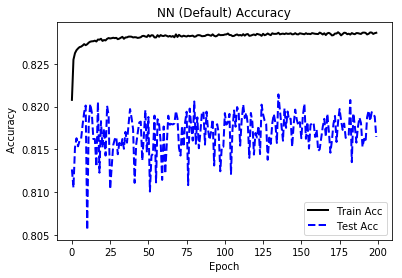

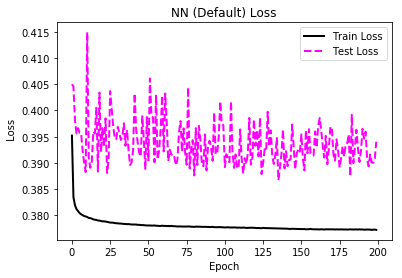

In [47]:
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_default, 'NN (Default)', 'nn_default', plots_path, False, True)

model_default acc: 81.65%


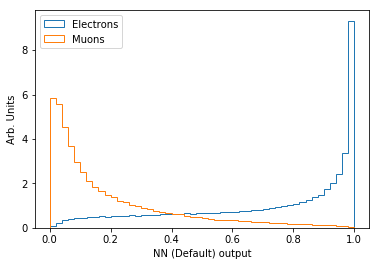

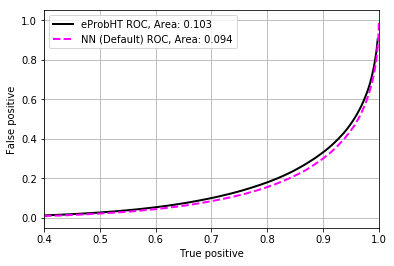

In [48]:
print("model_default %s: %.2f%%" % (model_default.metrics_names[1], model_default.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_default.predict(X_test[y_test>0.5], verbose=0), # el
                          model_default.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (Default)', 'nn_default', plots_path
                         )

fpr_model_default, tpr_model_default, thresholds_model_default = roc_curve(y_test, model_default.predict(X_test, verbose=0))
roc_model_default = [tpr_model_default, fpr_model_default, 'NN (Default)', 'nn_default', 'magenta', '--']

plot_roc([roc_eprob, roc_model_default], plots_path)

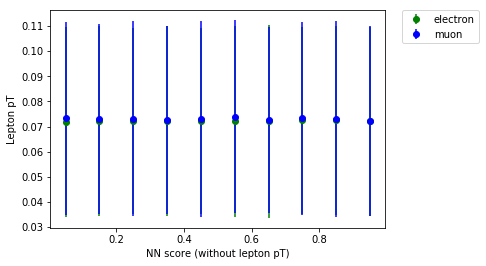

In [49]:
#df_test_pTlep = create_df(sig_file_name,sig_tree,['lep_pT'],len(X_test[y_test>0.5]),shuffle=False))
#sig_file_name, sig_tree, bkg_file_name, bkg_tree,
#    list(input_variables),
#    test_size=0.2,
df_sig_pTlep, df_bkg_pTlep, X_train_pTlep, X_test_pTlep, y_train_pTlep, y_test_pTlep = create_fixed_test_shuffled_train_and_scale(
    sig_file_name, sig_tree, bkg_file_name, bkg_tree,
    ['pT','lep_pT'],
    test_size=0.2,
    # test_size=0.333333,
    # sig_n=50000,
    # bkg_n=50000,
    scale_style={0: 'default', 1: 'default'},
    rnd_seed = rnd_seed
)
el_score = model_default.predict(X_test[y_test>0.5], verbose=0) #el
mu_score = model_default.predict(X_test[y_test<0.5], verbose=0) #mu
test_pTlep = np.delete(X_test_pTlep, 0, axis=1)

#print(test_pTlep[y_test<0.5])

#print(X_test[y_test<0.5])
el_pt = test_pTlep[y_test<0.5]
mu_pt = test_pTlep[y_test>0.5]

#elsortorder = el_score.argsort()
#el_ptsort = el_pt[elsortorder]

#musortorder = mu_score.argsort()
#mu_ptsort = mu_pt[musortorder]

N = 10
binpTel = []
binpTmu = []
binpTelerr = []
binpTmuerr = []
binscore = []
for i in range(N):
    el_ptbin = []
    binscore.append((2*i+1)*1./(2*N))
    for eli in range(len(el_pt)):
        if (el_score[eli] > (i)*1./N) and (el_score[eli] <= (i+1)*1./N):
            #print(el_pt[eli], (i)*1./N, (i+1)*1./N)
            el_ptbin.append(float(el_pt[eli]))
    mu_ptbin = []
    for mui in range(len(mu_pt)):
        if (mu_score[mui] >= (i)*1./N) and (mu_score[mui] < (i+1)*1./N):
            #print(mu_pt[mui], (i)*1./N, (i+1)*1./N)
            mu_ptbin.append(float(mu_pt[mui]))
    el_ptbin = np.array(el_ptbin)
    mu_ptbin = np.array(mu_ptbin)
    el_mean, el_std = el_ptbin.mean(), el_ptbin.std()
    binpTel.append(el_mean)
    binpTelerr.append(el_std)
    mu_mean, mu_std = mu_ptbin.mean(), mu_ptbin.std()
    binpTmu.append(mu_mean)
    binpTmuerr.append(mu_std)
    #mu_mean, mu_std = mu_ptbin.mean(), mu_ptbin.std()
#print(mu_ptbin)
#print(el_ptbin)

fig, ax = plt.subplots()
ax .errorbar(binscore, binpTel, binpTelerr, fmt='o', color = 'green', label='electron')
ax .errorbar(binscore, binpTmu, binpTmuerr, fmt='o', color = 'blue', label='muon')
ax.set_xlabel('NN score (without lepton pT)')
ax.set_ylabel('Lepton pT')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.show()
 
#print(type(el_score))
#print(len(el_score), len(X_test[y_test<0.5]), len(el_pt))
#print(len(mu_score), len(X_test[y_test>0.5]), len(mu_pt))

In [50]:
from keras.utils.vis_utils import plot_model
# pip install pydot

plot_model(model_default, to_file='plots/model_default.pdf', show_shapes=True, show_layer_names=True)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

## Wide

In [ ]:
fname_model_wide = 'model_wide'
train_load_model_wide = train_or_load(models_path+'/'+fname_model_wide+'.h5')

In [ ]:
if train_load_model_wide == 'n':
    
    # create
    model_wide = Sequential()
    model_wide.add(Dense(24, input_dim=input_ndimensions, activation='relu'))
    model_wide.add(Dense(16, activation='relu'))
    model_wide.add(Dense(1, activation='sigmoid'))

    model_wide.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_wide = model_wide.fit(X_train, y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_wide = hist_model_wide.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_wide.save(models_path+'/'+fname_model_wide+'.h5')
   
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_wide, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_wide = load_model(models_path+'/'+fname_model_wide+'.h5')
    
    with open(models_path+'/'+fname_model_wide+'_hist.pickle', 'rb') as handle:
        hist_dict_model_wide = pickle.load(handle)

In [ ]:
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_wide, 'NN (wide)', 'nn_wide', plots_path, False, True)

In [ ]:
print("model_wide %s: %.2f%%" % (model_wide.metrics_names[1], model_wide.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_wide.predict(X_test[y_test>0.5], verbose=0), # el
                          model_wide.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (wide)', 'nn_wide', plots_path
                         )

fpr_model_wide, tpr_model_wide, thresholds_model_wide = roc_curve(y_test, model_wide.predict(X_test, verbose=0))
roc_model_wide = [tpr_model_wide, fpr_model_wide, 'NN (wide)', 'nn_wide', 'cyan', '-.']

plot_roc([roc_eprob, roc_model_wide], plots_path)

## Deep

In [ ]:
fname_model_deep = 'model_deep'
train_load_model_deep = train_or_load(models_path+'/'+fname_model_deep+'.h5')

In [ ]:
if train_load_model_deep == 'n':
    
    # create
    model_deep = Sequential()
    model_deep.add(Dense(12, input_dim=input_ndimensions, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(8, activation='relu'))
    model_deep.add(Dense(1, activation='sigmoid'))

    model_deep.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train
    train_start = datetime.now()
    hist_model_deep = model_deep.fit(X_train, y_train,
                                           epochs=max_epochs, batch_size=50,
                                           verbose=fit_verbose, validation_data=val_data);

    hist_dict_model_deep = hist_model_deep.history
    print(strfdelta(datetime.now()-train_start, "Training time: {hours} hours, {minutes} minutes, {seconds} seconds"))

    # save model to HDF5, history to pickle
    model_deep.save(models_path+'/'+fname_model_deep+'.h5')
   
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'wb') as handle:
        pickle.dump(hist_dict_model_deep, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
else:
    # load model from HDF5, history from pickle
    model_deep = load_model(models_path+'/'+fname_model_deep+'.h5')
    
    with open(models_path+'/'+fname_model_deep+'_hist.pickle', 'rb') as handle:
        hist_dict_model_deep = pickle.load(handle)

In [ ]:
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, True, False)
plot_acc_loss_vs_epoch(hist_dict_model_deep, 'NN (deep)', 'nn_deep', plots_path, False, True)

In [ ]:
print("model_deep %s: %.2f%%" % (model_deep.metrics_names[1], model_deep.evaluate(X_test,y_test,verbose=0)[1]*100))

plot_classifier_1D_output(model_deep.predict(X_test[y_test>0.5], verbose=0), # el
                          model_deep.predict(X_test[y_test<0.5], verbose=0), # mu
                          'NN (deep)', 'nn_deep', plots_path
                         )

fpr_model_deep, tpr_model_deep, thresholds_model_deep = roc_curve(y_test, model_deep.predict(X_test, verbose=0))
roc_model_deep = [tpr_model_deep, fpr_model_deep, 'NN (deep)', 'nn_deep', 'darkorange', '--']

plot_roc([roc_eprob, roc_model_deep], plots_path)

## Compare all models

In [ ]:
all_models = []
all_models.append(roc_eprob)
all_models.append(roc_svm1)
all_models.append(roc_model_default)
all_models.append(roc_model_wide)
all_models.append(roc_model_deep)

plot_roc(all_models, plots_path)

roc_model_default_clean = list(roc_model_default)
roc_model_default_clean[2] = 'NN'
roc_model_default_clean[3] += '_clean'
plot_roc([roc_eprob, roc_svm1, roc_model_default_clean], plots_path)

## Mutual Information Plots

### Training Variables

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict, df_sig, 'Training Vars: $e$', 'train_var_el', plots_path)

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict, df_bkg, 'Training Vars: $\mu$', 'train_var_mu', plots_path)

In [ ]:
if plot_mi: mutual_info_plot(var_names_dict,
                             pd.concat([df_sig, df_bkg]),
                             'Training Vars: $e$ & $\mu$', 'train_var_el_mu', plots_path)

### All Variables

In [ ]:
all_vars=[
'p',
'pT',
'eta',
'nTRThitsMan',
'nTRTouts',
'fHTMB',
'fAr',
'trkOcc',
'sumToTsumL',
'lep_pT',
'phi',
'PHF',
'NhitsdEdx',
'sumToT',
'sumL',
'nTRThits',
'nArhits',
'nXehits',
'nHThitsMan',
'nPrechitsMan',
'eProbHT']

if plot_mi:
    df_sig_all_vars = create_df(sig_file_name, sig_tree, all_vars)
    df_bkg_all_vars = create_df(bkg_file_name, bkg_tree, all_vars)

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars}, df_sig_all_vars, 'All Vars: $e$', 'all_var_el', 'plots')

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars}, df_bkg_all_vars, 'All Vars: $\mu$', 'all_var_mu', 'plots')

In [ ]:
if plot_mi: mutual_info_plot({var:var for var in all_vars},
                             pd.concat([df_sig_all_vars, df_bkg_all_vars]),
                             'All Vars: $e$ & $\mu$', 'all_var_el_mu', 'plots')

In [ ]:
print("Total elapsed time: %s" % (strfdelta(datetime.now()-time_all_start, "{hours} hours, {minutes} minutes, {seconds} seconds")))

In [109]:
a = np.array([2, 3, 1])
print(a.mean(), a.std())

(2.0, 0.816496580927726)
